# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [53]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import joblib

import datetime
import time

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.window import Window
from pyspark.sql import Row
from pyspark.sql import functions as F
from pyspark.sql.functions import *

from pyspark.ml.feature import CountVectorizer, IDF, PCA, RegexTokenizer, VectorAssembler, Normalizer, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, LinearSVC, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, PCA, RegexTokenizer, VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [54]:
# create a Spark session
spark = SparkSession.builder \
                    .appName('Sparkkify Project') \
                    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [55]:
# Read mini_sparkify_event_data.json file
df_spark = spark.read.json('mini_sparkify_event_data.json')

### Try to clean spark dataframe

In [56]:
df_spark.describe()

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string]

In [57]:
df_spark.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [58]:
df_spark.count()

286500

In [59]:
df_spark.columns

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId']

In [60]:
# Check duplicate
if df_spark.count() > df_spark.dropDuplicates().count():
    raise ValueError('Data has duplicates')
else: print('No duplicate')

No duplicate


In [61]:
# Count N/A, Null values for each column
df_spark.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_spark.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



### There is no Null or N/A value in userid and sessionId columns

In [62]:
# Loop through df_spark columns and count number of missing values 
for col in df_spark.columns:
    missing_count = df_spark.filter(df_spark[col] == "").count()
    if missing_count > 0:
        print("{}: {}".format(col, missing_count))

userId: 8346


### There are 8346 empty values in userId column

In [63]:
# Keep only the none empty userId
df_spark = df_spark.filter(df_spark['userId'] != "")

In [64]:
df_spark.count()

278154

In [65]:
# a function to set churn = 1 if value = 'Cancellation Confirmation', otherwise 0
churn_event = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())

In [66]:
#creating churn column
df_spark = df_spark.withColumn("churn", churn_event("page"))

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [67]:
# Convert spark dataframe to pandas dataframe
df = df_spark.toPandas()

In [68]:
df.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,churn
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0


In [69]:
df.dtypes

artist            object
auth              object
firstName         object
gender            object
itemInSession      int64
lastName          object
length           float64
level             object
location          object
method            object
page              object
registration       int64
sessionId          int64
song              object
status             int64
ts                 int64
userAgent         object
userId            object
churn              int32
dtype: object

In [70]:
# Convert data type of userId column to numeric 
df['userId']= pd.to_numeric(df['userId'])

In [71]:
df.dtypes

artist            object
auth              object
firstName         object
gender            object
itemInSession      int64
lastName          object
length           float64
level             object
location          object
method            object
page              object
registration       int64
sessionId          int64
song              object
status             int64
ts                 int64
userAgent         object
userId             int64
churn              int32
dtype: object

In [72]:
# Show unique category in page column
df['page'].unique().tolist()

['NextSong',
 'Add to Playlist',
 'Roll Advert',
 'Thumbs Up',
 'Downgrade',
 'Thumbs Down',
 'Home',
 'Logout',
 'Help',
 'Upgrade',
 'Add Friend',
 'Settings',
 'Submit Upgrade',
 'About',
 'Submit Downgrade',
 'Error',
 'Save Settings',
 'Cancel',
 'Cancellation Confirmation']

In [73]:
# Count number of rows had page = Cancellation Confirmation
df[df['page'] == 'Cancellation Confirmation'].count()

artist            0
auth             52
firstName        52
gender           52
itemInSession    52
lastName         52
length            0
level            52
location         52
method           52
page             52
registration     52
sessionId        52
song              0
status           52
ts               52
userAgent        52
userId           52
churn            52
dtype: int64

### There are 52 users in our dataset that have churned

In [74]:
def is_churn(page):
    '''
    Check whether it is churn or not
    Params:
    Page: page colum
    '''
    if page == 'Cancellation Confirmation':
        is_churn = 1
    else: is_churn = 0
    return is_churn

In [75]:
# Create churn column
df_churned = []
for i in df['page']:
    df_churned.append(is_churn(i))

In [76]:
df_churned

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [77]:
# Set churned column = df_churned
df['churned'] = df_churned

In [78]:
#  Group churned by userId
churned_by_userId = df.groupby('userId').agg({'churned': 'sum'})
churned_by_userId.reset_index()

,userId,churned
0,2,0
1,3,1
2,4,0
3,5,0
4,6,0
5,7,0
6,8,0
7,9,0
8,10,0
9,11,0


In [79]:
# Calculate rate of churn
churn_rate = churned_by_userId[churned_by_userId['churned'] == 1].count()/churned_by_userId.count()
churn_rate

churned    0.231111
dtype: float64

In [80]:
# Count number of churned and not churned
churned_by_userId_df = churned_by_userId.groupby('churned').agg({'churned': 'count'})
churned_by_userId_df.rename(columns={'churned': 'Count'}, inplace=True)
churned_by_userId_df.index.names = ['Churned']
churned_by_userId_df.reset_index()

,Churned,Count
0,0,173
1,1,52


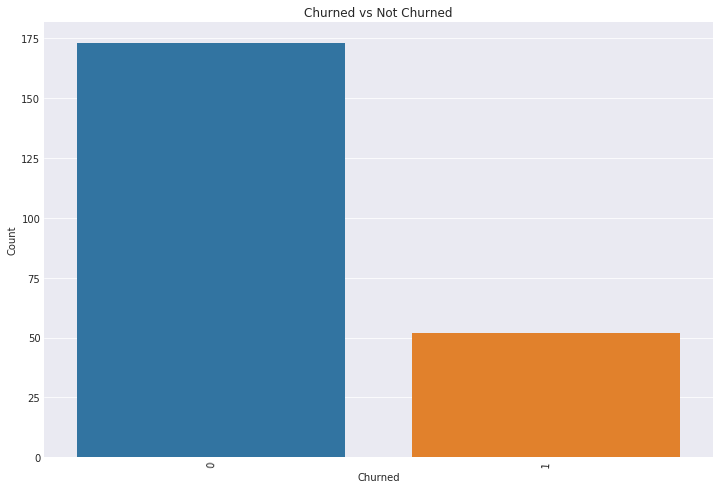

In [81]:
# Visualize the Top 15 Countries by Respondents
sns.set_style('darkgrid')
plt.figure(figsize=(12,8))
plt.xticks(rotation=86)
plt.title('Churned vs Not Churned')
sns.barplot(x=churned_by_userId_df.index, y=churned_by_userId_df['Count'])

## Churned by Gender

In [82]:
# create gender dataframe grouped by churn and gender
df_tmp = df.drop_duplicates(['userId','churned', 'gender'])
df_gender =  df_tmp.groupby(['churned', 'gender']).agg({'userId': 'count'})
df_gender.reset_index().sort_values('gender')
df_gender

userId
churned gender        
0       F          104
        M          121
1       F           20
        M           32

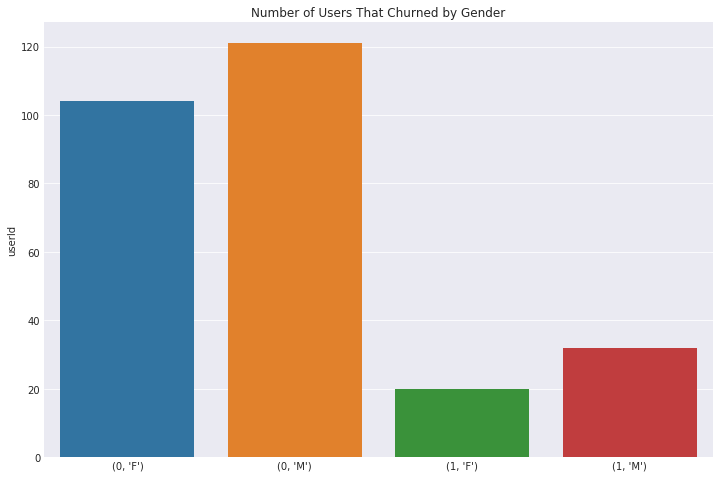

In [83]:
# Plot Churned by Gender
sns.set_style('darkgrid')
plt.figure(figsize=(12,8))
ax = sns.barplot(data = df_gender, x = df_gender.index, y=df_gender.userId)
plt.title("Number of Users That Churned by Gender");

## Churned by Level

In [84]:
# create level dataframe grouped by churn and level
df_tmp = df.drop_duplicates(['userId','churned', 'level'])
df_level =  df_tmp.groupby(['churned', 'level']).agg({'userId': 'count'})
df_level.reset_index()

,churned,level,userId
0,0,free,195
1,0,paid,165
2,1,free,21
3,1,paid,31


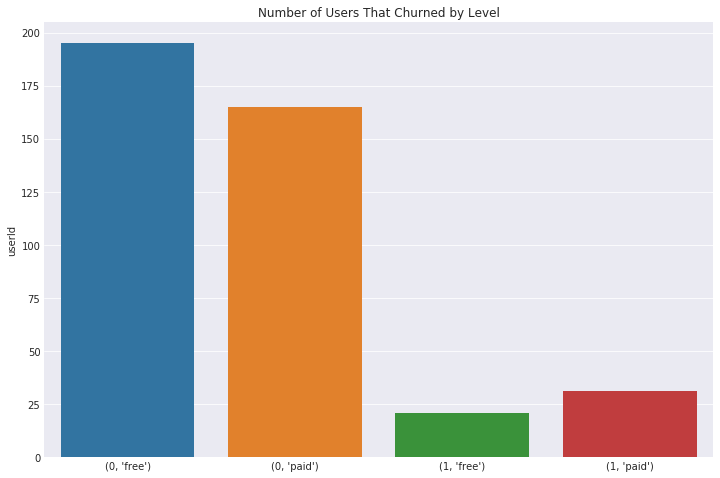

In [85]:
# Plot Churned by Level
sns.set_style('darkgrid')
plt.figure(figsize=(12,8))
ax = sns.barplot(data = df_level, x = df_level.index, y=df_level.userId)
plt.title("Number of Users That Churned by Level");

## Churned by itemInSession

In [86]:
# create itemInSession dataframe grouped by churn
df_tmp = df.drop_duplicates(['userId','churned', 'itemInSession'])
df_item =  df_tmp.groupby(['churned']).agg({'itemInSession': np.mean})
df_item.sort_values('itemInSession', ascending = False, inplace=True)
df_item

,itemInSession
churned,
0,215.264201
1,88.192308


Text(0.5,1,'Number of Users That Churned by itemInSession')

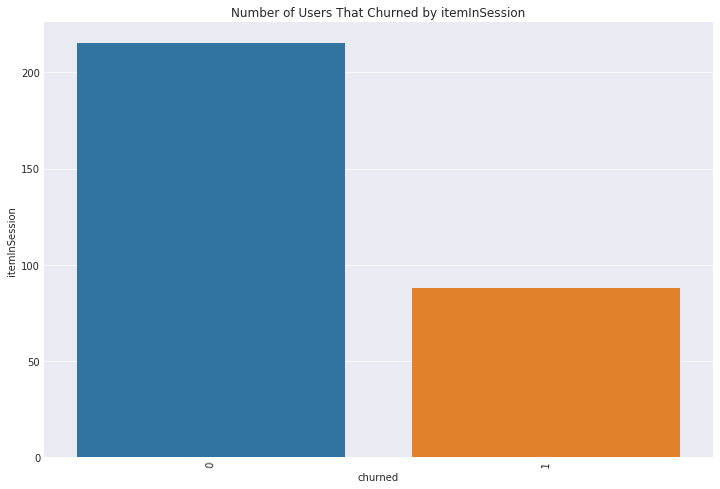

In [87]:
# Plot Churned by itemInSession
sns.set_style('darkgrid')
plt.figure(figsize=(12,8))
plt.xticks(rotation=86)
ax = sns.barplot(data = df_item, x = df_item.index, y=df_item.itemInSession)
plt.title('Number of Users That Churned by itemInSession')

### Churned by number of thumbs up actions

In [88]:
# Select sessionId and drop duplicate
df_spark.select("sessionId").dropDuplicates().sort("sessionId").show()

+---------+
|sessionId|
+---------+
|        1|
|        2|
|        3|
|        4|
|        5|
|        6|
|        7|
|        8|
|        9|
|       10|
|       11|
|       12|
|       13|
|       15|
|       16|
|       17|
|       18|
|       19|
|       20|
|       21|
+---------+
only showing top 20 rows



In [89]:
# Keep not empty values only
df_spark = df_spark.filter(df_spark["userId"] != "")

In [90]:
df_spark.count()

278154

In [91]:
# check Cancellation Confirmation page
df_spark.select("page").dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [92]:
# number of users who churned
df_spark.select(["userId", "page"]).where(df_spark.page == "Cancellation Confirmation").count()

52

In [95]:
# Sort records for a user in reverse time order so we can add up vals in churn column
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

In [96]:
# Create column churn which contains sum of churn 1s over records
df_spark = df_spark.withColumn("churn", Fsum("churn").over(windowval))

In [97]:
# Groupby churn to get counts
df_churn = df_spark.select(['userId', 'churn']).dropDuplicates().groupBy('churn').count()

In [98]:
df_churn.show()

+-----+-----+
|churn|count|
+-----+-----+
|    0|  173|
|    1|   52|
+-----+-----+



# Gender

In [99]:
# Create gender df grouped by churn and gender
df_gender = df_spark.select(['userId', 'churn', 'gender']).dropDuplicates().groupBy('gender', 'churn').count()
# Show gender df 
df_gender.show()

+------+-----+-----+
|gender|churn|count|
+------+-----+-----+
|     F|    0|   84|
|     F|    1|   20|
|     M|    0|   89|
|     M|    1|   32|
+------+-----+-----+



In [100]:
# Create df_page spark dataframe
df_page = df_spark.select(['userId', 'churn', 'page']).groupBy('page','churn').count()

In [101]:
# Convert df_page spark dataframe to pandas dataframe
df_page = df_page.toPandas()

In [102]:
# Create counts for those who churned and those who stayed
churn_count =  df_page[df_page['churn'] == 1].sum() 
stay_count =  df_page[df_page['churn'] == 0].sum()

In [103]:
# Calculate the rate of pages visited by those who churned vs. those who not churn
df_page['rate'] = np.where(
    df_page['churn'] == 0, df_page['count']/stay_count['count'], np.where(
    df_page['churn'] == 1, df_page['count']/churn_count['count'],df_page['count']/churn_count['count'])) 

In [106]:
df_page.head(40)

,page,churn,count,rate
0,Settings,0,1244,0.005332
1,Thumbs Down,1,496,0.011056
2,Thumbs Up,1,1859,0.041436
3,Add to Playlist,1,1038,0.023137
4,Error,1,32,0.000713
5,About,1,56,0.001248
6,Thumbs Down,0,2050,0.008787
7,Roll Advert,1,967,0.021554
8,Home,0,8410,0.036050
9,Cancellation Confirmation,1,52,0.001159


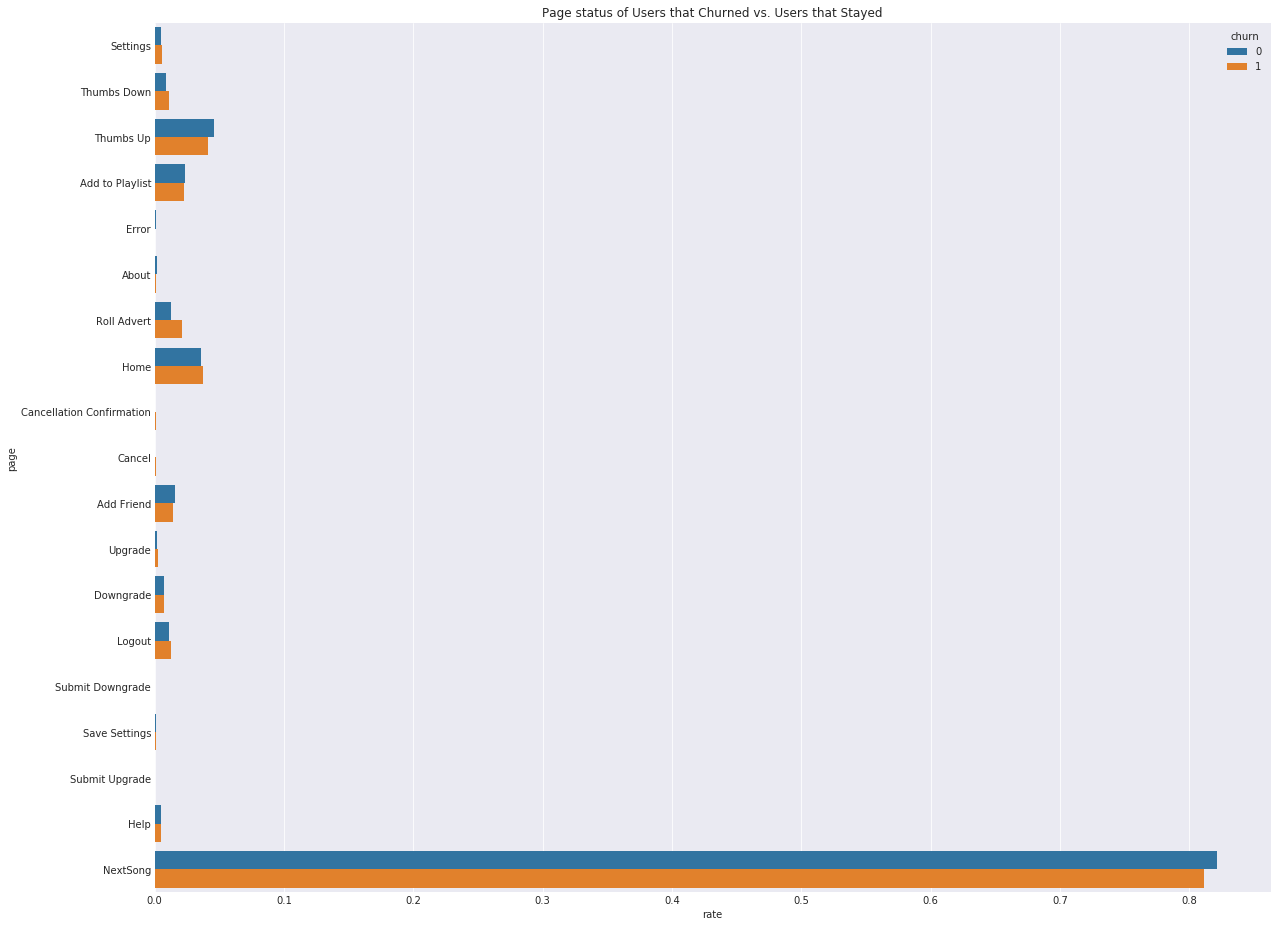

In [107]:
# Plot the pages by churn
plt.figure(figsize=[20,16])
sns.barplot(data = df_page, x = 'rate', y = 'page', hue = 'churn')
plt.title('Page status of Users that Churned vs. Users that Stayed');

In [108]:
# Create a copy of df_spark dataframe and convert it to pandas
df = df_spark.toPandas()

In [109]:
def get_hour(df):
    '''
    calculate hour by using timestamp
    df: data frame
    '''
    df_hour = []
    for ts in df['ts']:
        df_hour.append(datetime.datetime.fromtimestamp(ts / 1000.0). hour)
    return df_hour

In [110]:
# create hour column
df['hour'] = get_hour(df)
df['hour'].head()

0    18
1    18
2    18
3    18
4    18
Name: hour, dtype: int64

In [111]:
df.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,churn,hour
0,None,Logged In,Darianna,F,34,Carpenter,NaN,free,"Bridgeport-Stamford-Norwalk, CT",PUT,Logout,1538016340000,187,None,307,1542823952000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,18
1,Lily Allen,Logged In,Darianna,F,33,Carpenter,185.25995,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,187,22,200,1542823951000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,18
2,John Waite,Logged In,Darianna,F,32,Carpenter,269.76608,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,187,Missing You,200,1542823682000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,18
3,Hermano,Logged In,Darianna,F,31,Carpenter,115.90485,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,187,Letters From Madrid,200,1542823567000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,18
4,None,Logged In,Darianna,F,30,Carpenter,NaN,free,"Bridgeport-Stamford-Norwalk, CT",GET,Roll Advert,1538016340000,187,None,200,1542823257000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,18


In [112]:
# Count number of songs for not_churn group
songs_by_hour_not_churn = df[(df['page'] == 'NextSong') & (df['churn'] == 0)]
songs_by_hour_not_churn = songs_by_hour_not_churn.groupby(['hour']).agg({'song':'count'})
songs_by_hour_not_churn

,song
hour,
0,7527
1,7035
2,7014
3,7063
4,6914
5,6960
6,6836
7,6873
8,7023


Text(0.5,1,'Number of Songs by Hour in Churned group')

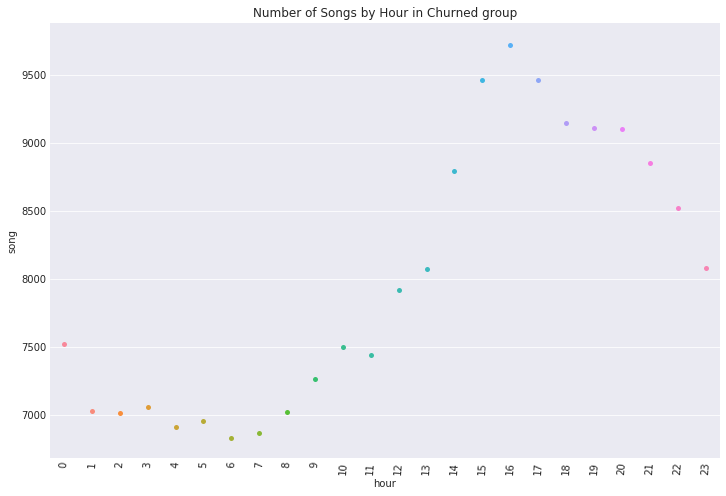

In [113]:
# Plot Churned by by hour in not_churn group
sns.set_style('darkgrid')
plt.figure(figsize=(12,8))
plt.xticks(rotation=86)
ax = sns.stripplot(data = songs_by_hour_not_churn, x = songs_by_hour_not_churn.index, y=songs_by_hour_not_churn.song)
plt.title('Number of Songs by Hour in Churned group')

In [114]:
# Count number of songs for churn group
songs_by_hour_churn = df[(df['churn'] == 1)]
songs_by_hour_churn = songs_by_hour_churn.groupby(['hour']).agg({'song':'count'})
songs_by_hour_churn

,song
hour,
0,1535
1,1353
2,1322
3,1292
4,1233
5,1218
6,1218
7,1218
8,1230


Text(0.5,1,'Number of Songs by Hour in Churned group')

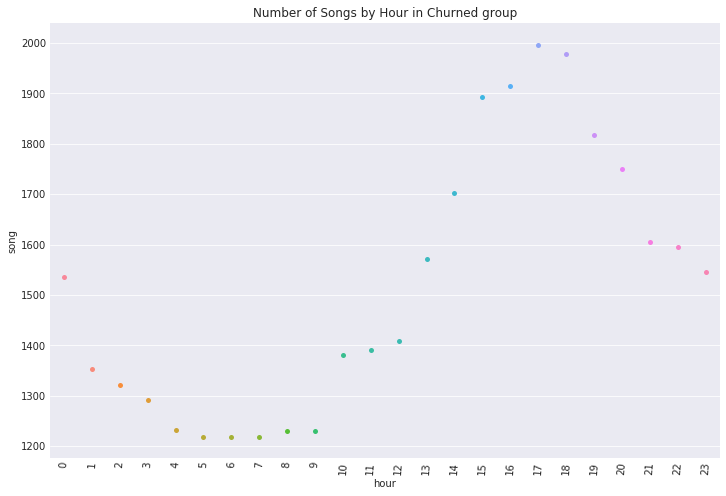

In [115]:
# Plot Churned by by hour in not_churn group
sns.set_style('darkgrid')
plt.figure(figsize=(12,8))
plt.xticks(rotation=86)
ax = sns.stripplot(data = songs_by_hour_churn, x = songs_by_hour_churn.index, y=songs_by_hour_churn.song)
plt.title('Number of Songs by Hour in Churned group')

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

* Chossing Features:

    * Gender
    * Level
    * Thumbs up
    * Number of items per section
    * Friend added
    * Hour
    * Songs added to playlist

## Gender feature

In [116]:
gender_feature = df_spark.select(['userId', 'gender']).dropDuplicates()

In [117]:
type(gender_feature)

pyspark.sql.dataframe.DataFrame

In [118]:
gender_type = udf(lambda x: 1 if x == "F" else 0, IntegerType())

In [119]:
# Create gender column 
gender_feature = gender_feature.withColumn("Gender", gender_type('gender'))

In [120]:
gender_feature.count()

225

In [121]:
# check
gender_feature.show(40)

+------+------+
|userId|Gender|
+------+------+
|    44|     1|
|    46|     1|
|    41|     1|
|    72|     1|
|300023|     1|
|    39|     1|
|100010|     1|
|    40|     1|
|    94|     1|
|    35|     1|
|    75|     1|
|   116|     1|
|200001|     0|
|200020|     0|
|100008|     1|
|200015|     0|
|   100|     0|
|100006|     1|
|300005|     1|
|    25|     1|
|    92|     1|
|200016|     1|
|100005|     0|
|    52|     1|
|   110|     0|
|200025|     0|
|    33|     0|
|    42|     1|
|100021|     0|
|300002|     1|
|    67|     0|
|300006|     0|
|    77|     1|
|100001|     1|
|   136|     1|
|300012|     0|
|    84|     1|
|    99|     1|
|300025|     0|
|   114|     0|
+------+------+
only showing top 40 rows



In [123]:
gender_feature

DataFrame[userId: string, Gender: int]

## Level feature

In [125]:
# Create df2 spark dataframe
df2 = df_spark.select(['userId', 'level', 'ts']).dropDuplicates().sort('userId')

In [126]:
# Create order by timestamp
so = Window.partitionBy("userId").orderBy(desc("ts"))

In [127]:
# Order df2
df2 = df2.withColumn("Rank", dense_rank().over(so))

In [128]:
df2.show()

+------+-----+-------------+----+
|userId|level|           ts|Rank|
+------+-----+-------------+----+
|    10| paid|1542631788000|   1|
|    10| paid|1542631753000|   2|
|    10| paid|1542631690000|   3|
|    10| paid|1542631518000|   4|
|    10| paid|1542631517000|   5|
|    10| paid|1542631090000|   6|
|    10| paid|1542630866000|   7|
|    10| paid|1542630637000|   8|
|    10| paid|1542630407000|   9|
|    10| paid|1542630394000|  10|
|    10| paid|1542630248000|  11|
|    10| paid|1542630247000|  12|
|    10| paid|1542630029000|  13|
|    10| paid|1542629861000|  14|
|    10| paid|1542629636000|  15|
|    10| paid|1542629464000|  16|
|    10| paid|1542629238000|  17|
|    10| paid|1542629029000|  18|
|    10| paid|1542629028000|  19|
|    10| paid|1542628798000|  20|
+------+-----+-------------+----+
only showing top 20 rows



In [132]:
# Drop Rank column
level_feature = df2.filter(df2.Rank == 1).drop(df2.Rank)

In [133]:
# Drop ts column also
level_feature = level_feature.drop('ts')

In [134]:
# a function to set Level = 1 if value = 'paid', otherwise 0
level_type = udf(lambda x: 1 if x == "paid" else 0, IntegerType())

In [135]:
# Create Level column
level_feature = level_feature.withColumn('Level', level_type('level'))

In [136]:
level_feature.count()

225

In [137]:
level_feature.show(20)

+------+-----+
|userId|Level|
+------+-----+
|    10|    1|
|   100|    1|
|100001|    0|
|100002|    1|
|100003|    0|
|100004|    1|
|100005|    0|
|100006|    0|
|100007|    1|
|100008|    0|
|100009|    0|
|100010|    0|
|100011|    0|
|100012|    0|
|100013|    1|
|100014|    1|
|100015|    1|
|100016|    0|
|100017|    0|
|100018|    0|
+------+-----+
only showing top 20 rows



## Thumb down feature

In [138]:
# Create thumbdown_feature with 2 columns 'userId', 'page'
thumbdown_feature = df_spark.select(['userId', 'page'])

In [139]:
# a function to set Thumbs_Down = 1 if value = 'Thumbs Down', otherwise 0
thumddown_event = udf(lambda x: 1 if x == 'Thumbs Down' else 0, IntegerType())

In [140]:
# Create Thumbs_Down column
thumbdown_feature = thumbdown_feature.withColumn('Thumbs_Down', thumddown_event('page'))

In [141]:
# Group thumbdown_feature by userId and count
thumbdown_feature = thumbdown_feature.groupby('userId').sum('Thumbs_Down')

In [143]:
# Sum Thumbs_Down
thumbdown_feature = thumbdown_feature.withColumnRenamed('sum(Thumbs_Down)', 'Thumbs_Down')

In [144]:
thumbdown_feature.show(20)

+------+-----------+
|userId|Thumbs_Down|
+------+-----------+
|100010|          5|
|200002|          6|
|   125|          0|
|    51|         21|
|   124|         41|
|     7|          1|
|    54|         29|
|    15|         14|
|   155|          3|
|   132|         17|
|   154|          0|
|100014|          3|
|   101|         16|
|    11|          9|
|   138|         24|
|300017|         28|
|    29|         22|
|    69|          9|
|100021|          5|
|    42|         25|
+------+-----------+
only showing top 20 rows



## Thums Up feature

In [145]:
# Create thumbup_feature with 2 columns 'userId', 'page'
thumbup_feature = df_spark.select(['userId', 'page'])

In [146]:
# a function to set Thumbs_Up = 1 if value = 'Thumbs Up', otherwise 0
thumbup_event = udf(lambda x: 1 if x == 'Thumbs Up' else 0, IntegerType())

In [147]:
# Create Thumbs_Down column
thumbup_feature = thumbup_feature.withColumn('Thumbs_Up', thumbup_event('page'))

In [148]:
# Group thumbdown_feature by userId and count
thumbup_feature = thumbup_feature.groupby('userId').sum('Thumbs_Up')

In [151]:
# Sum Thumbs_Down
thumbup_feature = thumbup_feature.withColumnRenamed('sum(Thumbs_Up)', 'Thumbs_Up')

In [152]:
thumbup_feature.count()

225

In [153]:
thumbup_feature.show(20)

+------+---------+
|userId|Thumbs_Up|
+------+---------+
|100010|       17|
|200002|       21|
|   125|        0|
|    51|      100|
|   124|      171|
|     7|        7|
|    54|      163|
|    15|       81|
|   155|       58|
|   132|       96|
|   154|       11|
|100014|       17|
|   101|       86|
|    11|       40|
|   138|       95|
|300017|      303|
|    29|      154|
|    69|       72|
|100021|       11|
|    42|      166|
+------+---------+
only showing top 20 rows



## Friend Added feature

In [154]:
# Create friend_feature with 2 columns 'userId', 'page'
friend_feature = df_spark.select(['userId', 'page'])

In [155]:
# a function to set add_friend = 1 if value = 'Add Friend', otherwise 0
add_friend = udf(lambda x: 1 if x == 'Add Friend' else 0, IntegerType())

In [156]:
# Create Friends column
friend_feature = friend_feature.withColumn('Friends', add_friend('page'))

In [157]:
# Group friend_feature by userId and sum('Friends')
friend_feature = friend_feature.groupby('userId').sum('Friends')

In [161]:
# Sum Friends
friend_feature = friend_feature.withColumnRenamed('sum(Friends)', 'Friends')

In [162]:
friend_feature.count()

225

In [163]:
friend_feature.show(20)

+------+-------+
|userId|Friends|
+------+-------+
|100010|      4|
|200002|      4|
|   125|      0|
|    51|     28|
|   124|     74|
|     7|      1|
|    54|     33|
|    15|     31|
|   155|     11|
|   132|     41|
|   154|      3|
|100014|      6|
|   101|     29|
|    11|      6|
|   138|     41|
|300017|     63|
|    29|     47|
|    69|     12|
|100021|      7|
|    42|     52|
+------+-------+
only showing top 20 rows



## Song Added feature

In [164]:
# Create song_feature with 2 columns 'userId', 'page'
song_feature = df_spark.select(['userId', 'page'])

In [165]:
# a function to set add_playlist = 1 if value = 'Add to Playlist', otherwise 0
add_playlist = udf(lambda x: 1 if x == 'Add to Playlist' else 0, IntegerType())

In [166]:
# Create Songs column
song_feature = song_feature.withColumn('Songs', add_playlist('page'))

In [167]:
# Group Songs by userId and sum('Songs')
song_feature = song_feature.groupby('userId').sum('Songs')

In [168]:
# Sum Songs
song_feature = song_feature.withColumnRenamed('sum(Songs)', 'Songs')

In [169]:
song_feature.count()

225

In [170]:
song_feature.show(20)

+------+-----+
|userId|Songs|
+------+-----+
|100010|    7|
|200002|    8|
|   125|    0|
|    51|   52|
|   124|  118|
|     7|    5|
|    54|   72|
|    15|   59|
|   155|   24|
|   132|   38|
|   154|    1|
|100014|    7|
|   101|   61|
|    11|   20|
|   138|   67|
|300017|  113|
|    29|   89|
|    69|   33|
|100021|    7|
|    42|  104|
+------+-----+
only showing top 20 rows



## Label column

In [171]:
# Create label
label = df_spark.select('userId', 'churn').dropDuplicates().groupby('userId', 'churn').count()

In [172]:
# Drop count colum
label = label.drop('count')

In [173]:
label.count()

225

In [174]:
# Keep 'churn', 'label' column label
label = label.withColumnRenamed("churn", "label")

In [176]:
label.show()

+------+-----+
|userId|label|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|   124|    0|
|    51|    1|
|     7|    0|
|    15|    0|
|    54|    1|
|   155|    0|
|100014|    1|
|   132|    0|
|   154|    0|
|   101|    1|
|    11|    0|
|   138|    0|
|300017|    0|
|100021|    1|
|    29|    1|
|    69|    0|
|   112|    0|
+------+-----+
only showing top 20 rows



## Hour feature

In [177]:
# Create hour feature dataframe
hour_feature = df.copy()
hour_feature

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,churn,hour
0,None,Logged In,Darianna,F,34,Carpenter,NaN,free,"Bridgeport-Stamford-Norwalk, CT",PUT,Logout,1538016340000,187,None,307,1542823952000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,18
1,Lily Allen,Logged In,Darianna,F,33,Carpenter,185.25995,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,187,22,200,1542823951000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,18
2,John Waite,Logged In,Darianna,F,32,Carpenter,269.76608,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,187,Missing You,200,1542823682000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,18
3,Hermano,Logged In,Darianna,F,31,Carpenter,115.90485,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,187,Letters From Madrid,200,1542823567000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,18
4,None,Logged In,Darianna,F,30,Carpenter,NaN,free,"Bridgeport-Stamford-Norwalk, CT",GET,Roll Advert,1538016340000,187,None,200,1542823257000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,18
5,Hot Chip,Logged In,Darianna,F,29,Carpenter,319.42485,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,187,Alley Cats,200,1542823248000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,18
6,Eminem,Logged In,Darianna,F,28,Carpenter,302.57587,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,187,Taking My Ball,200,1542822946000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,17
7,The Police,Logged In,Darianna,F,27,Carpenter,305.05751,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,187,Walking On The Moon,200,1542822641000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,17
8,Ke$ha,Logged In,Darianna,F,26,Carpenter,207.64689,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,187,Kiss N Tell,200,1542822434000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,17
9,Gwen Stefani,Logged In,Darianna,F,25,Carpenter,264.93342,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,187,Luxurious,200,1542822170000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,17


In [178]:
# create hour column
hour_feature['Hour'] = get_hour(hour_feature)
hour_feature['Hour'].head()

0    18
1    18
2    18
3    18
4    18
Name: Hour, dtype: int64

In [179]:
# Create Hour feature for each user
hour_feature['Hour'] = get_hour(hour_feature) # create Hour column
hour_feature = hour_feature.filter(['userId', 'Hour']) # Keep 'userId', 'Hour' columns only
hour_feature = hour_feature.groupby('userId').agg({'Hour':'sum'}) # Sum Thumbs Up action for each user
hour_feature.reset_index(inplace=True)
hour_feature

,userId,Hour
0,10,9322
1,100,39845
2,100001,1669
3,100002,3101
4,100003,1108
5,100004,13971
6,100005,3724
7,100006,625
8,100007,5169
9,100008,13134


In [180]:
# Convert hour_feature to pandas dataframe
hour_feature = spark.createDataFrame(hour_feature)

## Create features dataset

In [181]:
# Create list of feature
feature_list = [gender_feature, level_feature, \
                thumbup_feature, thumbdown_feature, \
                friend_feature, hour_feature, song_feature, label]

In [182]:
# Create feature_df by merge all features above
feature_df = gender_feature.join(level_feature, ["userId"]).join(thumbup_feature, \
                            ["userId"]).join(thumbdown_feature, ["userId"]).join(friend_feature, ["userId"])\
                            .join(hour_feature, ["userId"]).join(song_feature, ["userId"]).join(label, ["userId"])

In [183]:
feature_df.show()

+------+------+-----+---------+-----------+-------+-----+-----+-----+
|userId|Gender|Level|Thumbs_Up|Thumbs_Down|Friends| Hour|Songs|label|
+------+------+-----+---------+-----------+-------+-----+-----+-----+
|100010|     1|    0|       17|          5|      4| 4295|    7|    0|
|200002|     0|    1|       21|          6|      4| 7356|    8|    0|
|   125|     0|    0|        0|          0|      0|   44|    0|    1|
|   124|     1|    1|      171|         41|     74|61545|  118|    0|
|    51|     0|    1|      100|         21|     28|29286|   52|    1|
|     7|     0|    0|        7|          1|      1| 1813|    5|    0|
|    15|     0|    1|       81|         14|     31|29318|   59|    0|
|    54|     1|    1|      163|         29|     33|42211|   72|    1|
|   155|     1|    1|       58|          3|     11| 9911|   24|    0|
|100014|     0|    1|       17|          3|      6| 4878|    7|    1|
|   132|     1|    1|       96|         17|     41|31147|   38|    0|
|   154|     1|    0

## Preprocessing

In [184]:
# Show schema
feature_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- Gender: integer (nullable = true)
 |-- Level: integer (nullable = true)
 |-- Thumbs_Up: long (nullable = true)
 |-- Thumbs_Down: long (nullable = true)
 |-- Friends: long (nullable = true)
 |-- Hour: long (nullable = true)
 |-- Songs: long (nullable = true)
 |-- label: long (nullable = true)



In [185]:
# Cast all columns to float
for feature in feature_df.columns:
    print(feature)
    feature_df = feature_df.withColumn(feature, feature_df[feature].cast('float'))

userId
Gender
Level
Thumbs_Up
Thumbs_Down
Friends
Hour
Songs
label


In [186]:
# Show schema
feature_df.printSchema()

root
 |-- userId: float (nullable = true)
 |-- Gender: float (nullable = true)
 |-- Level: float (nullable = true)
 |-- Thumbs_Up: float (nullable = true)
 |-- Thumbs_Down: float (nullable = true)
 |-- Friends: float (nullable = true)
 |-- Hour: float (nullable = true)
 |-- Songs: float (nullable = true)
 |-- label: float (nullable = true)



## Vector Assembler

In [187]:
# Create vector Assembler
assembler = VectorAssembler(inputCols = ['Gender', 'Level', 'Thumbs_Up', 'Thumbs_Down','Friends',\
                                         'Hour', 'Songs'], outputCol = 'vec_features')

In [188]:
# Transform feature_df
feature_df = assembler.transform(feature_df)

In [189]:
feature_df.show()

+--------+------+-----+---------+-----------+-------+-------+-----+-----+--------------------+
|  userId|Gender|Level|Thumbs_Up|Thumbs_Down|Friends|   Hour|Songs|label|        vec_features|
+--------+------+-----+---------+-----------+-------+-------+-----+-----+--------------------+
|100010.0|   1.0|  0.0|     17.0|        5.0|    4.0| 4295.0|  7.0|  0.0|[1.0,0.0,17.0,5.0...|
|200002.0|   0.0|  1.0|     21.0|        6.0|    4.0| 7356.0|  8.0|  0.0|[0.0,1.0,21.0,6.0...|
|   125.0|   0.0|  0.0|      0.0|        0.0|    0.0|   44.0|  0.0|  1.0|      (7,[5],[44.0])|
|   124.0|   1.0|  1.0|    171.0|       41.0|   74.0|61545.0|118.0|  0.0|[1.0,1.0,171.0,41...|
|    51.0|   0.0|  1.0|    100.0|       21.0|   28.0|29286.0| 52.0|  1.0|[0.0,1.0,100.0,21...|
|     7.0|   0.0|  0.0|      7.0|        1.0|    1.0| 1813.0|  5.0|  0.0|[0.0,0.0,7.0,1.0,...|
|    15.0|   0.0|  1.0|     81.0|       14.0|   31.0|29318.0| 59.0|  0.0|[0.0,1.0,81.0,14....|
|    54.0|   1.0|  1.0|    163.0|       29.0|   33

## Standardization

In [190]:
# Create a StandardScaler
scaler = StandardScaler(inputCol="vec_features", outputCol="features", withStd=True)

In [191]:
# Fit scaler
scaler_model = scaler.fit(feature_df)

In [192]:
# Transform feature_df
feature_df = scaler_model.transform(feature_df)

In [193]:
feature_df.head(20)

[Row(userId=100010.0, Gender=1.0, Level=0.0, Thumbs_Up=17.0, Thumbs_Down=5.0, Friends=4.0, Hour=4295.0, Songs=7.0, label=0.0, vec_features=DenseVector([1.0, 0.0, 17.0, 5.0, 4.0, 4295.0, 7.0]), features=DenseVector([2.0013, 0.0, 0.2596, 0.3823, 0.1943, 0.2638, 0.214])),
 Row(userId=200002.0, Gender=0.0, Level=1.0, Thumbs_Up=21.0, Thumbs_Down=6.0, Friends=4.0, Hour=7356.0, Songs=8.0, label=0.0, vec_features=DenseVector([0.0, 1.0, 21.0, 6.0, 4.0, 7356.0, 8.0]), features=DenseVector([0.0, 2.0844, 0.3207, 0.4588, 0.1943, 0.4518, 0.2445])),
 Row(userId=125.0, Gender=0.0, Level=0.0, Thumbs_Up=0.0, Thumbs_Down=0.0, Friends=0.0, Hour=44.0, Songs=0.0, label=1.0, vec_features=SparseVector(7, {5: 44.0}), features=SparseVector(7, {5: 0.0027})),
 Row(userId=124.0, Gender=1.0, Level=1.0, Thumbs_Up=171.0, Thumbs_Down=41.0, Friends=74.0, Hour=61545.0, Songs=118.0, label=0.0, vec_features=DenseVector([1.0, 1.0, 171.0, 41.0, 74.0, 61545.0, 118.0]), features=DenseVector([2.0013, 2.0844, 2.6116, 3.1352, 3.

## Train / Test Split

In [215]:
# Slit data to train and test set
train, test = feature_df.randomSplit([0.8, 0.2])
print("Training Dataset:" + str(train.count()))
print("Test Dataset:" + str(test.count()))

Training Dataset:172
Test Dataset:53


In [195]:
train.head()

Row(userId=200002.0, Gender=0.0, Level=1.0, Thumbs_Up=21.0, Thumbs_Down=6.0, Friends=4.0, Hour=7356.0, Songs=8.0, label=0.0, vec_features=DenseVector([0.0, 1.0, 21.0, 6.0, 4.0, 7356.0, 8.0]), features=DenseVector([0.0, 2.0844, 0.3207, 0.4588, 0.1943, 0.4518, 0.2445]))

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [196]:
# Instantiate all of our models and include a seed for reproduciblity where possible
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', seed=2000)
nv = NaiveBayes(featuresCol = 'features', labelCol = 'label')

In [216]:
def train_model(model, train, test):
    '''
    Train, test and evaluate a model
    Params:
    Model: a model
    train: train dataset
    test: test dataset
    '''
    
    model_name = model.__class__.__name__
    # Print training started
    print(model_name, ' training started')
    
    # Fit the models on train dataset
    model = model.fit(train)

    # Print training ended
    print(model, 'training ended')
    
    # Testing
    print(model_name, ' predicting started')
    predictions = model.transform(test)
    print(model_name, 'predicting ended')
    
    # Get metrics to evaluate
    # Evaluator we are using is multiclassclassificationevaluator to get the F1 scores
    evaluator = MulticlassClassificationEvaluator(labelCol = 'label', predictionCol='prediction')
    #  Get f1 metrics to evaluate
    print('F1 for {} is:'.format(model_name), evaluator.evaluate(predictions, {evaluator.metricName: "f1"}))
    # Get Accuracy
    accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
    print("The accuracy of the {} model is:".format(model_name), accuracy)

In [217]:
# Train, test and evaluate Random Forest model
train_model(rf, train, test)

RandomForestClassifier  training started
RandomForestClassificationModel (uid=RandomForestClassifier_d5bc42508413) with 20 trees training ended
RandomForestClassifier  predicting started
RandomForestClassifier predicting ended
F1 for RandomForestClassifier is: 0.6303130831432718
The accuracy of the RandomForestClassifier model is: 0.7169811320754716


In [218]:
# Train, test and evaluate NaiveBayes model
train_model(nv, train, test)

NaiveBayes  training started
NaiveBayes_ed7c37f67575 training ended
NaiveBayes  predicting started
NaiveBayes predicting ended
F1 for NaiveBayes is: 0.6492189085007101
The accuracy of the NaiveBayes model is: 0.7547169811320755


## Tuning model

In [202]:
# Let's see what parameters we can tune.
print(rf.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

#### Choose numTrees and maxDepth for the model tuning.

In [203]:
# Create ParamGridBuilder
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees,[20, 50, 100]) \
    .addGrid(rf.maxDepth,[5, 10, 15]) \
    .build()

# Create Cross-Validator
cross_vallidate = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName = "f1"),
                          numFolds=3)

In [205]:
# Fit Cross-Validator
cvModel = cross_vallidate.fit(train)

In [206]:
# Extract everage metrics of Cross-Validator
cvModel.avgMetrics

[0.6949016998018412,
 0.6717895793382885,
 0.6658359203653059,
 0.6735984144333886,
 0.6700721433250075,
 0.6700721433250075,
 0.6568848931065449,
 0.6667933567958164,
 0.6667933567958164]

In [207]:
# Transform test dataset
results = cvModel.transform(test)

In [209]:
# Create best model
best_model = cvModel.bestModel

In [210]:
print ('Best Param (numTrees): ', best_model._java_obj.getNumTrees())
print ('Best Param (MaxDepth): ', best_model._java_obj.getMaxDepth())

Best Param (numTrees):  20
Best Param (MaxDepth):  5


In [211]:
print('F1 for our best model is:', evaluator.evaluate(results, {evaluator.metricName: "f1"}))

F1 for our best model is: 0.7141633352370074


In [212]:
print('Accuracy for our best model is:', evaluator.evaluate(results, {evaluator.metricName: "accuracy"}))

Accuracy for our best model is: 0.7833333333333333


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.